### Surrogate model for DTLZ2 problem

Problem setup

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import minimize
from pymoo.problems.many import DTLZ2
import numpy as np

np.random.seed(0)

# Problem Definition
n_obj = 3
k = 20
n_vars = n_obj + k - 1 
problem = DTLZ2(n_var=n_vars, n_obj=n_obj)

def scalarized_objective(x, lambdas):
    
    f = problem.evaluate(np.array([x]))[0]  
    
    return np.dot(lambdas, f)  


def optimize_for_lambda(lambdas, x_range=(0.0, 1.0)):
    
    lambdas = np.array(lambdas)
    
    if not np.isclose(np.sum(lambdas), 1.0) or np.any(lambdas < 0):
        raise ValueError("lambdas must be non-negative and sum to 1")
    
    objective = lambda x: scalarized_objective(x, lambdas)
    
    # Use multiple starting points to avoid local minima
    starting_points = np.linspace(x_range[0], x_range[1], 10)
    best_result = None
    lowest_loss = float('inf')
    
    for start in starting_points:
        result = minimize(objective, 
                          x0=np.full(n_vars, start), 
                          bounds=[(x_range[0], x_range[1])] * n_vars, 
                          method='L-BFGS-B')
        if result.fun < lowest_loss:
            lowest_loss = result.fun
            best_result = result
    
    return best_result.x, best_result.fun




Plots the optimal loss surface for different lambda combinations (lambda1, lambda2 and lambda3)

In [ ]:
def plot_optimal_values_surface():
    
    
    resolution = 20
    lambda1_vals = np.linspace(0, 1, resolution)
    lambda2_vals = np.linspace(0, 1, resolution)
    # OSS: lambda3 = 1 - lambda1 - lambda2
    
    valid_lambda1 = []
    valid_lambda2 = []
    valid_lambda3 = []
    optimal_losses = []
    optimal_x_values = []
    
    
    for l1 in lambda1_vals:
        for l2 in lambda2_vals:
            l3 = 1 - l1 - l2
            
            
            if l3 >= 0:
                lambdas = np.array([l1, l2, l3])
                x_min, loss_min = optimize_for_lambda(lambdas)
                
                valid_lambda1.append(l1)
                valid_lambda2.append(l2)
                valid_lambda3.append(l3)
                optimal_losses.append(loss_min)
                optimal_x_values.append(x_min)
    
    
    valid_lambda1 = np.array(valid_lambda1)
    valid_lambda2 = np.array(valid_lambda2)
    valid_lambda3 = np.array(valid_lambda3)
    optimal_losses = np.array(optimal_losses)
    optimal_x_values = np.array(optimal_x_values)
    
   
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    scatter = ax.scatter(valid_lambda1, valid_lambda2, valid_lambda3,
                         c=optimal_losses, cmap=cm.viridis, 
                         s=50, alpha=0.8)
    
    
    colorbar = fig.colorbar(scatter, ax=ax, shrink=0.5, aspect=5)
    colorbar.set_label('Optimal Loss Value', fontsize=12)
    

    ax.set_xlabel('Lambda 1')
    ax.set_ylabel('Lambda 2')
    ax.set_zlabel('Lambda 3')
    ax.set_title('Optimal loss for Different Lambda Combinations')
    
    plt.savefig('optimal_loss_surface_3d.png', dpi=300)
    return fig



Optimal solutions for specific lambda combinations:
--------------------------------------------------
Lambda               | Optimal Loss
--------------------------------------------------
[0.33, 0.33, 0.33]   |     0.333333
[0.80, 0.10, 0.10]   |     0.100000
[0.10, 0.80, 0.10]   |     0.100000
[0.10, 0.10, 0.80]   |     0.100000


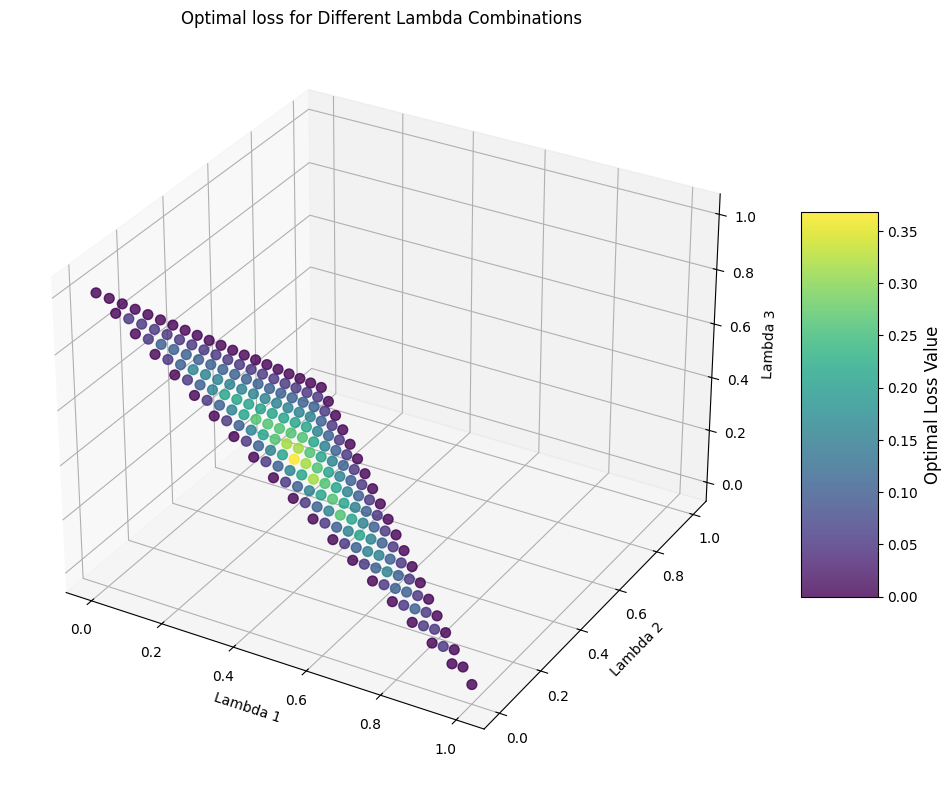

In [ ]:
# Execute the code
if __name__ == "__main__":
    
    # Plot the optimal loss 3D surface
    plot_optimal_values_surface()
    
    # Sample a few specific lambda combinations and print their optimal values
    lambda_combinations = [
        [1/3, 1/3, 1/3],  # Equal weights
        [0.8, 0.1, 0.1],   # Mostly λ1
        [0.1, 0.8, 0.1],   # Mostly λ2
        [0.1, 0.1, 0.8]    # Mostly λ3
    ]
    
    print("\nOptimal solutions for specific lambda combinations:")
    print("-" * 50)
    print(f"{'Lambda':20s} | {'Optimal Loss':12s}")
    print("-" * 50)
    
    # Calcolo e stampa delle soluzioni ottimali per ogni combinazione di lambda
    for lambdas in lambda_combinations:
        _, loss_min = optimize_for_lambda(lambdas)
        lambda_str = f"[{lambdas[0]:.2f}, {lambdas[1]:.2f}, {lambdas[2]:.2f}]"
        print(f"{lambda_str:20s} | {loss_min:12.6f}")
        
    plt.show()

Computes a 3x3 covariance matrix to measure the sensitivity of the optimal loss to small changes in lambda values.
Generates random lambda samples from the simplex (lambda1 + lambda2 = 1).

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import minimize
import pandas as pd
from tqdm import tqdm


def calculate_lambda_covariance(lambdas, delta=0.01):
    """
    Calculate the covariance matrix showing how the optimal loss changes
    with small perturbations in lambda values
    
    Parameters:
    lambdas: Base lambda values [λ1, λ2, λ3] where sum is 1
    delta: Small perturbation amount for finite difference approximation
    
    Returns:
    3x3 covariance matrix
    """
    # Calculate the optimal loss at the base lambda point
    x_opt, base_loss = optimize_for_lambda(lambdas)
    
    # Store perturbed losses
    perturbed_losses = np.zeros((3, 3))
    
    # For each pair of lambdas, calculate the perturbation effect
    for i in range(3):
        for j in range(3):
            if i == j:
                # Diagonal elements - single parameter perturbation
                if i < 2:  # Only perturb λ1 and λ2 directly
                    lambda_perturbed = lambdas.copy()
                    # Add delta to λi and subtract from λ3 to maintain sum=1
                    lambda_perturbed[i] += delta
                    lambda_perturbed[2] -= delta
                    
                    # Make sure we're still in the valid simplex
                    if np.all(lambda_perturbed >= 0):
                        x_pert, pert_loss = optimize_for_lambda(lambda_perturbed)
                        perturbed_losses[i, i] = (pert_loss - base_loss) / delta
                    else:
                        # If outside simplex, use a smaller delta in the opposite direction
                        lambda_perturbed = lambdas.copy()
                        lambda_perturbed[i] -= delta
                        lambda_perturbed[2] += delta
                        
                        if np.all(lambda_perturbed >= 0):
                            x_pert, pert_loss = optimize_for_lambda(lambda_perturbed)
                            perturbed_losses[i, i] = (base_loss - pert_loss) / delta
                        else:
                            # If still outside, use a very small perturbation
                            perturbed_losses[i, i] = 0
                else:
                    # For λ3, perturb λ1 and λ2 slightly down
                    lambda_perturbed = lambdas.copy()
                    lambda_perturbed[0] -= delta/2
                    lambda_perturbed[1] -= delta/2
                    lambda_perturbed[2] += delta
                    
                    if np.all(lambda_perturbed >= 0):
                        x_pert, pert_loss = optimize_for_lambda(lambda_perturbed)
                        perturbed_losses[2, 2] = (pert_loss - base_loss) / delta
                    else:
                        perturbed_losses[2, 2] = 0
            
            elif i < 2 and j < 2:
                # Off-diagonal elements for λ1 and λ2
                # Perturb both λi and λj while maintaining sum=1
                lambda_perturbed = lambdas.copy()
                lambda_perturbed[i] += delta/2
                lambda_perturbed[j] += delta/2
                lambda_perturbed[2] -= delta
                
                if np.all(lambda_perturbed >= 0):
                    x_pert, pert_loss = optimize_for_lambda(lambda_perturbed)
                    single_i_change = perturbed_losses[i, i] * delta/2
                    single_j_change = perturbed_losses[j, j] * delta/2
                    total_change = pert_loss - base_loss
                    interaction = total_change - single_i_change - single_j_change
                    perturbed_losses[i, j] = interaction / ((delta/2) * (delta/2))
                    perturbed_losses[j, i] = perturbed_losses[i, j]  # Symmetric matrix
                else:
                    perturbed_losses[i, j] = 0
                    perturbed_losses[j, i] = 0
            
            elif i < 2 and j == 2:
                # Off-diagonal for λ1/λ3 and λ2/λ3
                lambda_perturbed = lambdas.copy()
                lambda_perturbed[i] += delta/2
                lambda_perturbed[j] += delta/2
                lambda_perturbed[1-i] -= delta  # Adjust the other parameter
                
                if np.all(lambda_perturbed >= 0):
                    x_pert, pert_loss = optimize_for_lambda(lambda_perturbed)
                    single_i_change = perturbed_losses[i, i] * delta/2
                    single_j_change = perturbed_losses[j, j] * delta/2
                    total_change = pert_loss - base_loss
                    interaction = total_change - single_i_change - single_j_change
                    perturbed_losses[i, j] = interaction / ((delta/2) * (delta/2))
                    perturbed_losses[j, i] = perturbed_losses[i, j]  # Symmetric
                else:
                    perturbed_losses[i, j] = 0
                    perturbed_losses[j, i] = 0
    
    return perturbed_losses

def sample_from_simplex(n_samples):
    return np.random.dirichlet(np.ones(3), n_samples)

def generate_lambda_covariance_samples(n_samples=1000):
    # Generate lambda samples
    lambda_samples = sample_from_simplex(n_samples)
    
    # Initialize arrays to store results
    results = []
    
    # Calculate optimal values and covariances
    for i in tqdm(range(n_samples), desc="Calculating covariances"):
        lambdas = lambda_samples[i]
        x_opt, loss_opt = optimize_for_lambda(lambdas)
        
        # Calculate covariance matrix
        cov_matrix = calculate_lambda_covariance(lambdas)
        
        # Flatten the covariance matrix for storage
        cov_flat = cov_matrix.flatten()
        
        # Store results
        results.append({
            'lambda1': lambdas[0],
            'lambda2': lambdas[1],
            'lambda3': lambdas[2],
            'x_optimal': x_opt,
            'loss_optimal': loss_opt,
            'cov_11': cov_matrix[0, 0],
            'cov_12': cov_matrix[0, 1],
            'cov_13': cov_matrix[0, 2],
            'cov_21': cov_matrix[1, 0],
            'cov_22': cov_matrix[1, 1],
            'cov_23': cov_matrix[1, 2],
            'cov_31': cov_matrix[2, 0],
            'cov_32': cov_matrix[2, 1],
            'cov_33': cov_matrix[2, 2],
            'sensitivity_norm': np.linalg.norm(cov_matrix)
        })
    return pd.DataFrame(results)


Visualizes the sensitivity of the optimal loss to lambda perturbations.

In [ ]:
def visualize_covariance_results(df):
    """
    Create visualizations for the lambda-covariance samples using the DTLZ2 benchmark problem.
    """
    # 1. Plot the sensitivity norm on the simplex
    fig1, ax1 = plt.subplots(figsize=(10, 8))
    scatter = ax1.scatter(df['lambda1'], df['lambda2'], c=df['sensitivity_norm'], 
                          cmap='viridis', s=30, alpha=0.7)
    plt.colorbar(scatter, label='Sensitivity Norm (Covariance Matrix)')
    
    # Add the simplex boundary
    ax1.plot([0, 1, 0, 0], [0, 0, 1, 0], 'k-', linewidth=1.5)
    
    # Add labels
    ax1.text(0, 0, 'λ3 = 1', fontsize=12, ha='center', va='center')
    ax1.text(1, 0, 'λ1 = 1', fontsize=12, ha='center', va='center')
    ax1.text(0, 1, 'λ2 = 1', fontsize=12, ha='center', va='center')
    
    ax1.set_xlabel('Lambda 1', fontsize=12)
    ax1.set_ylabel('Lambda 2', fontsize=12)
    ax1.set_title('Sensitivity of Optimal Loss to Lambda Perturbations (DTLZ2)', fontsize=14)
    ax1.set_aspect('equal')
    
    plt.savefig('sensitivity_norm_simplex_dtlz2.png', dpi=300)
    
    # 2. Histogram of sensitivity norms
    fig2, ax2 = plt.subplots(figsize=(10, 6))
    ax2.hist(df['sensitivity_norm'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
    ax2.set_xlabel('Sensitivity Norm', fontsize=12)
    ax2.set_ylabel('Frequency', fontsize=12)
    ax2.set_title('Distribution of Sensitivity Norms (DTLZ2)', fontsize=14)
    
    plt.savefig('sensitivity_norm_histogram_dtlz2.png', dpi=300)
    
    # 3. 3D scatter plot of lambdas and sensitivity
    fig3 = plt.figure(figsize=(12, 10))
    ax3 = fig3.add_subplot(111, projection='3d')
    
    scatter3 = ax3.scatter(df['lambda1'], df['lambda2'], df['lambda3'], 
                           c=df['sensitivity_norm'], cmap='plasma', s=30, alpha=0.7)
    
    ax3.set_xlabel('Lambda 1', fontsize=12)
    ax3.set_ylabel('Lambda 2', fontsize=12)
    ax3.set_zlabel('Lambda 3', fontsize=12)
    ax3.set_title('Lambda Values, Sensitivity, and Optimal Loss (DTLZ2)', fontsize=14)
    
    fig3.colorbar(scatter3, ax=ax3, label='Sensitivity Norm')
    
    plt.savefig('lambda_sensitivity_3d_dtlz2.png', dpi=300)
    
    return fig1, fig2, fig3


Generating 1000 lambda-covariance samples...


Calculating covariances: 100%|██████████| 1000/1000 [24:03<00:00,  1.44s/it]


Saved 1000 lambda-covariance samples to lambda_covariance_samples.csv
Creating visualizations...

Summary statistics of sensitivity norms:
count    1000.000000
mean      699.634046
std       338.360156
min         1.000000
25%       565.686530
50%       632.456520
75%       848.529905
max      4943.739874
Name: sensitivity_norm, dtype: float64


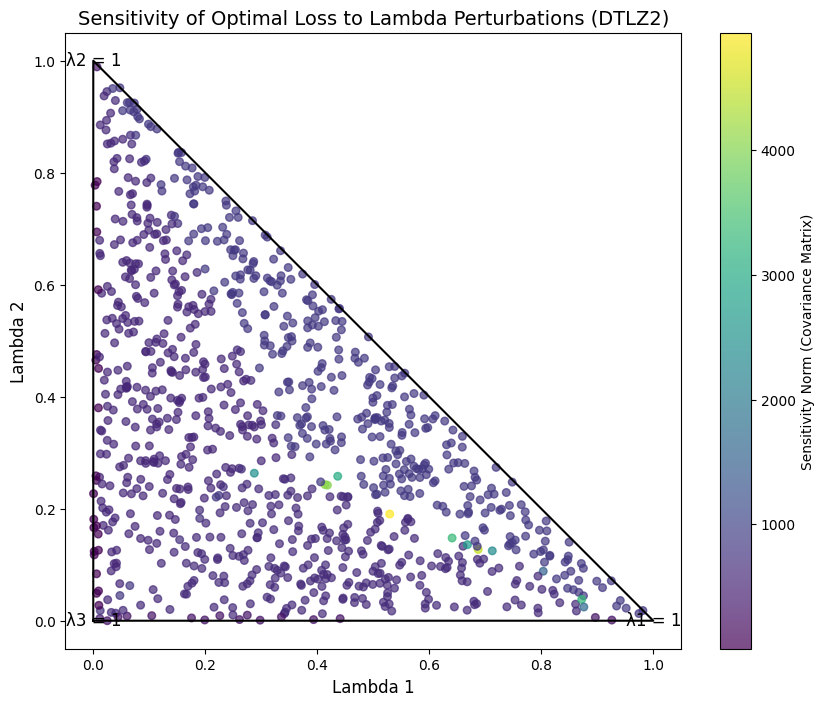

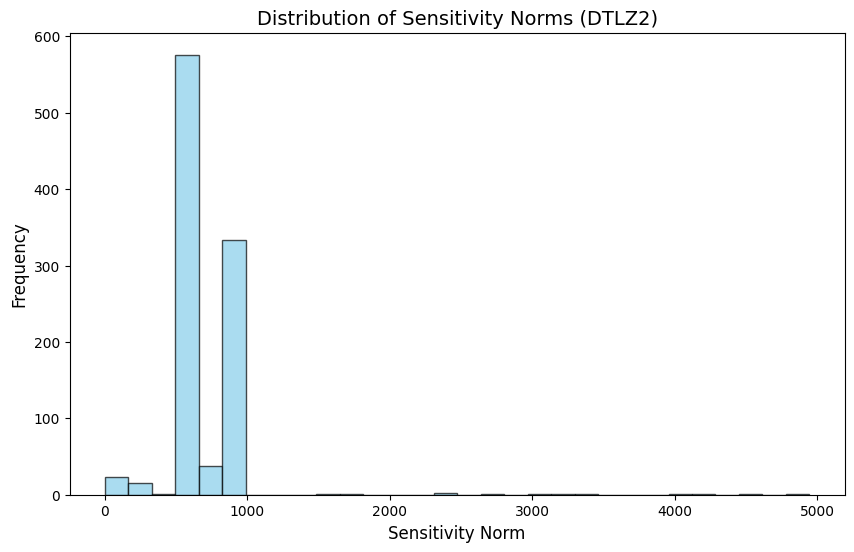

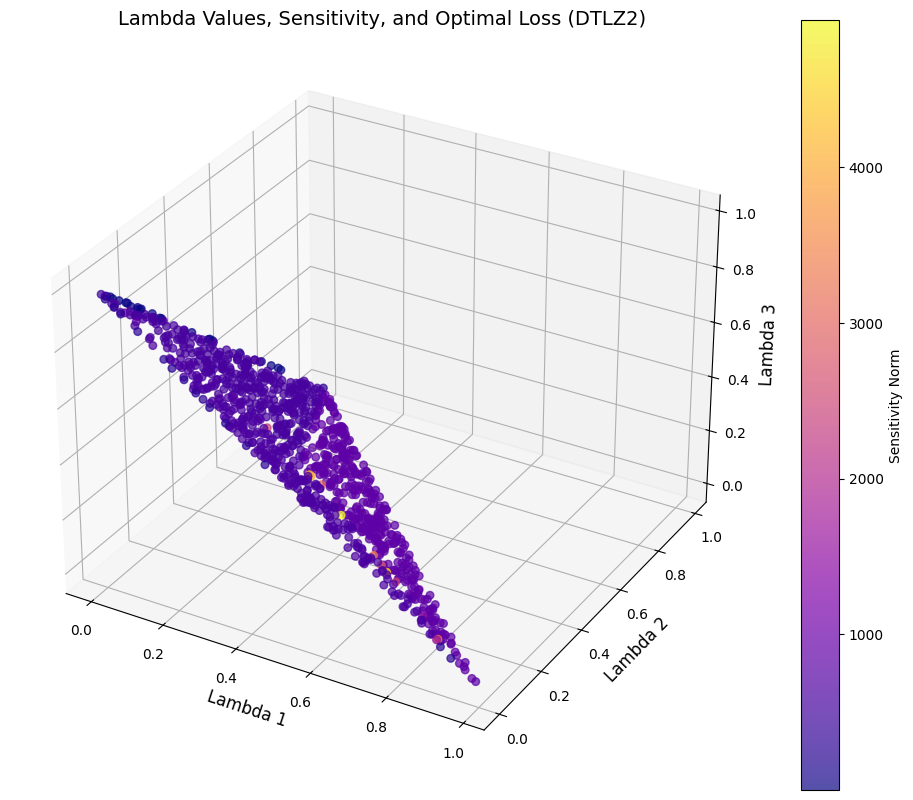

In [ ]:
if __name__ == "__main__":
    
    # Generate samples of lambda and covariance pairs
    print("\nGenerating 1000 lambda-covariance samples...")
    lambda_cov_samples = generate_lambda_covariance_samples(n_samples=1000)
    
    # Save the samples to CSV
    lambda_cov_samples.to_csv('loss.csv', index=False)
    print(f"Saved {len(lambda_cov_samples)} lambda-covariance samples to lambda_covariance_samples.csv")
    
    # Visualize the results
    print("Creating visualizations...")
    visualize_covariance_results(lambda_cov_samples)
    
    # Display summary statistics
    print("\nSummary statistics of sensitivity norms:")
    print(lambda_cov_samples['sensitivity_norm'].describe())
    
    # Show the plots
    plt.show()

Fits a Gaussian Process model to predict the sensitivity norm based on lambda values.
Evaluates the model's performance using metrics like MSE, RMSE, MAE, and R².


In [35]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import (
    RBF, Matern, WhiteKernel, ConstantKernel, RationalQuadratic
)
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Load the data generated by the DTLZ2 benchmark problem
def load_lambda_covariance_data(file_path='loss.csv'):
    """Load the lambda-covariance data from CSV file"""
    return pd.read_csv(file_path)

def fit_gp_model(data, n_training=100, random_state=42):
    """
    Fit a Gaussian Process model to predict sensitivity_norm from lambda values
    using a state-of-the-art kernel configuration with learnable parameters.
    
    Parameters:
    data: DataFrame with lambda and sensitivity data
    n_training: Number of samples to use for training
    random_state: Random seed for reproducibility
    
    Returns:
    model: Fitted GP model
    X_train, X_test: Training and test feature sets
    y_train, y_test: Training and test target values
    scaler_X, scaler_y: Data scalers
    """
    # Extract features (lambda1, lambda2) and target (sensitivity_norm)
    # lambda3 is calculated as 1 - lambda1 - lambda2 to respect the simplex constraint
    data['lambda3'] = 1 - data['lambda1'] - data['lambda2']
    X = data[['lambda1', 'lambda2']].values  # lambda3 is redundant
    y = data['sensitivity_norm'].values.reshape(-1, 1)
    
    # Split the data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, train_size=n_training, random_state=random_state
    )
    
    # Scale the data
    scaler_X = StandardScaler().fit(X_train)
    scaler_y = StandardScaler().fit(y_train)
    
    X_train_scaled = scaler_X.transform(X_train)
    y_train_scaled = scaler_y.transform(y_train)
    
    # Define a state-of-the-art kernel combination:
    amplitude = ConstantKernel(constant_value=1.0, constant_value_bounds=(0.01, 10.0))
    rbf = RBF(length_scale=[1.0, 1.0], length_scale_bounds=(0.01, 10.0))
    rational_quad = RationalQuadratic(length_scale=1.0, alpha=0.5, 
                                      length_scale_bounds=(0.01, 10.0),
                                      alpha_bounds=(0.1, 10.0))
    matern = Matern(length_scale=[1.0, 1.0], nu=1.5, 
                    length_scale_bounds=(0.01, 10.0))
    noise = WhiteKernel(noise_level=0.1, noise_level_bounds=(1e-10, 1.0))
    
    # Combine the kernels
    kernel = amplitude * (0.5 * rbf + 0.3 * rational_quad + 0.2 * matern) + noise
    
    print("Initial kernel configuration:")
    print(kernel)
    
    # Create and fit the GP model
    model = GaussianProcessRegressor(
        kernel=kernel,
        alpha=1e-10,  # Small alpha for numerical stability
        normalize_y=False,  # We already scaled the data
        n_restarts_optimizer=15,  # More restarts to find better hyperparameters
        random_state=random_state
    )
    
    # Fit the model
    print("\nFitting Gaussian Process model with optimized kernel...")
    model.fit(X_train_scaled, y_train_scaled)
    
    print(f"\nOptimized kernel parameters:")
    print(model.kernel_)
    
    # Print the learned noise level
    if hasattr(model.kernel_, 'k2') and hasattr(model.kernel_.k2, 'noise_level'):
        print(f"\nLearned noise level: {model.kernel_.k2.noise_level:.6f}")
    else:
        for param_name, param in model.kernel_.get_params().items():
            if isinstance(param, WhiteKernel):
                print(f"\nLearned noise level: {param.noise_level:.6f}")
    
    # Log marginal likelihood (higher is better)
    print(f"\nLog marginal likelihood: {model.log_marginal_likelihood(model.kernel_.theta):.4f}")
    
    return model, X_train, X_test, y_train, y_test, scaler_X, scaler_y

def evaluate_model(model, X_test, y_test, scaler_X, scaler_y):
    """
    Evaluate the GP model on test data
    
    Returns:
    y_pred: Predicted values
    metrics: Dictionary of evaluation metrics
    """
    # Scale the test data
    X_test_scaled = scaler_X.transform(X_test)
    
    # Make predictions
    y_pred_scaled, y_std_scaled = model.predict(X_test_scaled, return_std=True)
    
    # Unscale the predictions
    y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1))
    y_std = y_std_scaled * scaler_y.scale_
    
    # Calculate metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    metrics = {
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'R²': r2
    }
    
    return y_pred, y_std, metrics

Scatter plot to compare the predicted objective values from the Gaussian Process model against the true objective values.
Visualizes the Gaussian Process model's predicted objective surface over the lambda simplex.
Overlays the training and test points on the plots to show how well the model fits the data.

In [36]:
def plot_gp_surface_with_test_points(model, X_train, X_test, y_train, y_test, y_pred, 
                                    y_std, scaler_X, scaler_y):
    """
    Plot the GP model surface and the test points for the DTLZ2 problem
    """
    # Create a grid for the lambda simplex
    resolution = 50
    l1 = np.linspace(0, 1, resolution)
    l2 = np.linspace(0, 1, resolution)
    L1, L2 = np.meshgrid(l1, l2)
    
    # Filter out points outside the simplex (lambda1 + lambda2 <= 1)
    valid_indices = (L1 + L2 <= 1)
    
    # Create a mesh grid of lambda values
    X_mesh = np.column_stack((L1.ravel(), L2.ravel()))
    
    # Only keep points inside the simplex
    valid_points = X_mesh[np.ravel(valid_indices)]
    
    # Scale the points and predict
    X_mesh_scaled = scaler_X.transform(valid_points)
    y_mesh_scaled, y_mesh_std_scaled = model.predict(X_mesh_scaled, return_std=True)
    
    # Unscale the predictions
    y_mesh = scaler_y.inverse_transform(y_mesh_scaled.reshape(-1, 1)).ravel()
    y_mesh_std = y_mesh_std_scaled * scaler_y.scale_
    
    # Set up the 3D figure
    fig = plt.figure(figsize=(14, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    # Reshape for plotting
    L1_valid = valid_points[:, 0]
    L2_valid = valid_points[:, 1]
    
    # Plot the GP surface using triangulation
    ax.plot_trisurf(L1_valid, L2_valid, y_mesh, 
                   cmap=cm.viridis, alpha=0.7, linewidth=0.2, edgecolor='gray')
    
    # Plot training points in red
    ax.scatter(X_train[:, 0], X_train[:, 1], y_train, 
              color='red', s=5, label='Training points')
    
    # Plot test points in blue
    ax.scatter(X_test[:, 0], X_test[:, 1], y_test, 
              color='blue', s=8, label='Test points')
    
    # Set labels and title
    ax.set_xlabel('Lambda 1')
    ax.set_ylabel('Lambda 2')
    ax.set_zlabel('Sensitivity Norm')
    ax.set_title('GP Model of Sensitivity for DTLZ2')
    ax.legend()
    
    plt.savefig('gp_sensitivity_surface_dtlz2.png', dpi=300, bbox_inches='tight')
    
    # Create a 2D plot of the model prediction on the simplex with uncertainty
    fig2, ax2 = plt.subplots(figsize=(10, 8))
    
    # Create a triangulation for plotting
    triang_plot = plt.matplotlib.tri.Triangulation(L1_valid, L2_valid)
    
    # Plot the mean prediction
    tcf = ax2.tricontourf(triang_plot, y_mesh, levels=20, cmap='viridis')
    plt.colorbar(tcf, ax=ax2, label='Predicted Sensitivity Norm')
    
    # Plot the training and test points
    ax2.scatter(X_train[:, 0], X_train[:, 1], c='red', s=30, alpha=0.7, label='Training')
    ax2.scatter(X_test[:, 0], X_test[:, 1], c='blue', s=30, alpha=0.7, label='Test')
    
    # Add the simplex boundary
    ax2.plot([0, 1, 0, 0], [0, 0, 1, 0], 'k-')
    
    # Labels
    ax2.text(0, 0, 'λ3 = 1', fontsize=12)
    ax2.text(1, 0, 'λ1 = 1', fontsize=12)
    ax2.text(0, 1, 'λ2 = 1', fontsize=12)
    
    ax2.set_xlabel('Lambda 1')
    ax2.set_ylabel('Lambda 2')
    ax2.set_title('GP Model Prediction on Lambda Simplex (DTLZ2)')
    ax2.set_aspect('equal')
    ax2.legend()
    
    plt.savefig('gp_sensitivity_2d_dtlz2.png', dpi=300, bbox_inches='tight')
    
    return fig, fig2

def plot_predicted_vs_true(y_test, y_pred, y_std):
    """
    Create a scatter plot of predicted vs true sensitivity norms for DTLZ2
    """
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Plot the diagonal perfect prediction line
    max_val = max(np.max(y_test), np.max(y_pred))
    min_val = min(np.min(y_test), np.min(y_pred))
    ax.plot([min_val, max_val], [min_val, max_val], 'k--', label='Perfect prediction')
    
    # Plot the predictions with error bars (95% confidence intervals)
    ax.errorbar(y_test.ravel(), y_pred.ravel(), yerr=1.96*y_std, 
                fmt='o', markersize=8, alpha=0.6, 
                ecolor='lightgray', capsize=5)
    
    # Add correlation coefficient
    correlation = np.corrcoef(y_test.ravel(), y_pred.ravel())[0, 1]
    ax.annotate(f'Correlation: {correlation:.4f}', xy=(0.05, 0.95), 
                xycoords='axes fraction', fontsize=12)
    
    # Set labels and title
    ax.set_xlabel('True Sensitivity Norm')
    ax.set_ylabel('Predicted Sensitivity Norm')
    ax.set_title('Predicted vs. True Sensitivity Norm (DTLZ2)')
    
    # Add a grid for better readability
    ax.grid(True, alpha=0.3)
    
    # Make the plot square
    ax.set_aspect('equal')
    
    plt.tight_layout()
    plt.savefig('predicted_vs_true_dtlz2.png', dpi=300)
    
    return fig

def plot_gp_surface_with_test_points_enhanced(model, X_train_orig, y_train_orig, X_test_orig, y_test_orig, 
                                              y_pred_test, test_point_errors, scaler_X_fitted, scaler_y_fitted,
                                              title_suffix="Covariance Norm"):
    """
    Plot the GP model surface, training points, and test points (colored by error).
    X_train_orig, y_train_orig, X_test_orig, y_test_orig are unscaled original values.
    y_pred_test are unscaled predictions for X_test_orig.
    test_point_errors are absolute errors for test points.
    scaler_X_fitted, scaler_y_fitted are the fitted scalers.
    """
    fig = plt.figure(figsize=(15, 12))
    ax = fig.add_subplot(111, projection='3d')
    
    # 1. Create a grid for the lambda simplex surface
    resolution = 40
    l1_lin = np.linspace(0, 1, resolution)
    l2_lin = np.linspace(0, 1, resolution)
    L1_mesh, L2_mesh = np.meshgrid(l1_lin, l2_lin)
    
    # Valid points in the simplex (l1 + l2 <= 1)
    valid_simplex_indices = (L1_mesh + L2_mesh <= 1.001) # Add small tolerance
    
    grid_l1 = L1_mesh[valid_simplex_indices]
    grid_l2 = L2_mesh[valid_simplex_indices]
    
    X_grid = np.column_stack((grid_l1.ravel(), grid_l2.ravel()))
    
    # Scale grid points and predict
    X_grid_scaled = scaler_X_fitted.transform(X_grid)
    y_grid_scaled, _ = model.predict(X_grid_scaled, return_std=True) # std not used for surface here
    y_grid_pred = scaler_y_fitted.inverse_transform(y_grid_scaled.reshape(-1,1)).ravel()

    # 2. Plot the GP surface using triangulation
    # The surface is for the mean prediction
    surf = ax.plot_trisurf(grid_l1, grid_l2, y_grid_pred, cmap=cm.viridis, alpha=0.7, 
                           linewidth=0.1, antialiased=True, edgecolor='none', shade=True)
    fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10, pad=0.1, label=f'Predicted {title_suffix}')

    # 3. Plot training points (unscaled)
    ax.scatter(X_train_orig[:, 0], X_train_orig[:, 1], y_train_orig.ravel(), 
               c='blue', marker='o', s=30, label='Training Points', alpha=0.7, depthshade=False, edgecolors='w', linewidth=0.5)

    # 4. Plot test points (unscaled), colored by their absolute error
    # Ensure test_point_errors has a suitable range for colormap
    min_err, max_err = np.min(test_point_errors), np.max(test_point_errors)
    if min_err == max_err: # Handle case with uniform error (e.g., single test point)
        normalized_errors = np.ones_like(test_point_errors) * 0.5
    else:
        normalized_errors = (test_point_errors - min_err) / (max_err - min_err)

    error_cmap = cm.get_cmap('Reds')
    test_point_colors = error_cmap(normalized_errors)

    sc_test = ax.scatter(X_test_orig[:, 0], X_test_orig[:, 1], y_test_orig.ravel(), 
                         c=test_point_colors, marker='^', s=50, label='Test Points (Actual)', 
                         alpha=0.9, depthshade=False, edgecolors='k', linewidth=0.5)
    
    # Create a colorbar for test point errors
    # This requires a bit of manual setup for a scatter plot with colors mapped to values
    # One way is to use a ScalarMappable
    sm = plt.cm.ScalarMappable(cmap=error_cmap, norm=plt.Normalize(vmin=min_err, vmax=max_err))
    sm.set_array([]) # You need to set an array for the ScalarMappable, even an empty one
    cbar_errors = fig.colorbar(sm, ax=ax, shrink=0.5, aspect=10, pad=0.02, label='Absolute Prediction Error on Test Points')


    # 5. Aesthetics and Labels
    ax.set_xlabel('$\lambda_1$', fontsize=14)
    ax.set_ylabel('$\lambda_2$', fontsize=14)
    ax.set_zlabel(f'True/Predicted {title_suffix}', fontsize=14)
    ax.set_title(f'GP Model of {title_suffix} with Test Points', fontsize=16, pad=20)
    
    # Simplex boundary lines for clarity
    ax.plot([0, 1], [0, 0], [ax.get_zlim()[0], ax.get_zlim()[0]], 'k-', alpha=0.5, linewidth=1.5) # l1 axis
    ax.plot([0, 0], [0, 1], [ax.get_zlim()[0], ax.get_zlim()[0]], 'k-', alpha=0.5, linewidth=1.5) # l2 axis
    ax.plot([1, 0], [0, 1], [ax.get_zlim()[0], ax.get_zlim()[0]], 'k-', alpha=0.5, linewidth=1.5) # l1+l2=1 line
    
    ax.legend(loc='upper left', bbox_to_anchor=(0.02, 0.98))
    ax.view_init(elev=25, azim=-40) # Adjust view angle for better visualization
    plt.tight_layout()
    plt.show()
    return fig



Loading lambda-covariance data for DTLZ2...
Loaded 1000 samples.
Initial kernel configuration:
1**2 * 0.707**2 * RBF(length_scale=[1, 1]) + 0.548**2 * RationalQuadratic(alpha=0.5, length_scale=1) + 0.447**2 * Matern(length_scale=[1, 1], nu=1.5) + WhiteKernel(noise_level=0.1)

Fitting Gaussian Process model with optimized kernel...


c:\Users\aless\Desktop\Tesi\Articolo\.venv\lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__k2__k2__alpha is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\aless\Desktop\Tesi\Articolo\.venv\lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 1 of parameter k1__k2__k2__k2__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(



Optimized kernel parameters:
0.285**2 * 3.3**2 * RBF(length_scale=[0.0288, 0.124]) + 2.21**2 * RationalQuadratic(alpha=10, length_scale=1.89) + 0.00532**2 * Matern(length_scale=[0.115, 10], nu=1.5) + WhiteKernel(noise_level=1.8e-10)

Learned noise level: 0.000000

Log marginal likelihood: -567.9193

Model performance on test data:
MSE: 87229.2375
RMSE: 295.3460
MAE: 78.9419
R²: 0.1992

Creating visualizations...

Generating 3D GP Surface Plot...


C:\Users\aless\AppData\Local\Temp\ipykernel_14684\1071885487.py:177: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  error_cmap = cm.get_cmap('Reds')


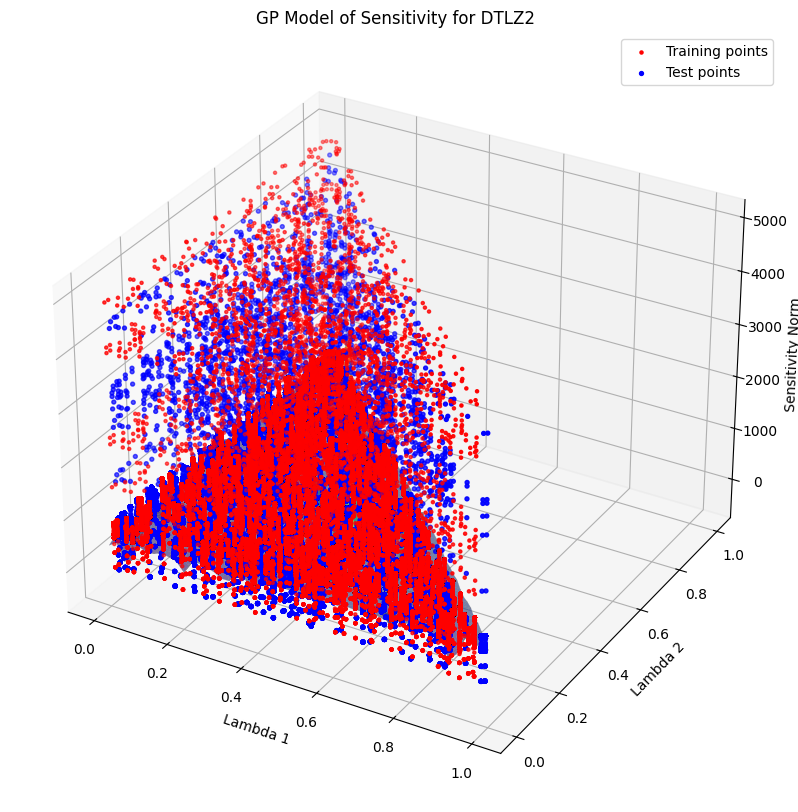

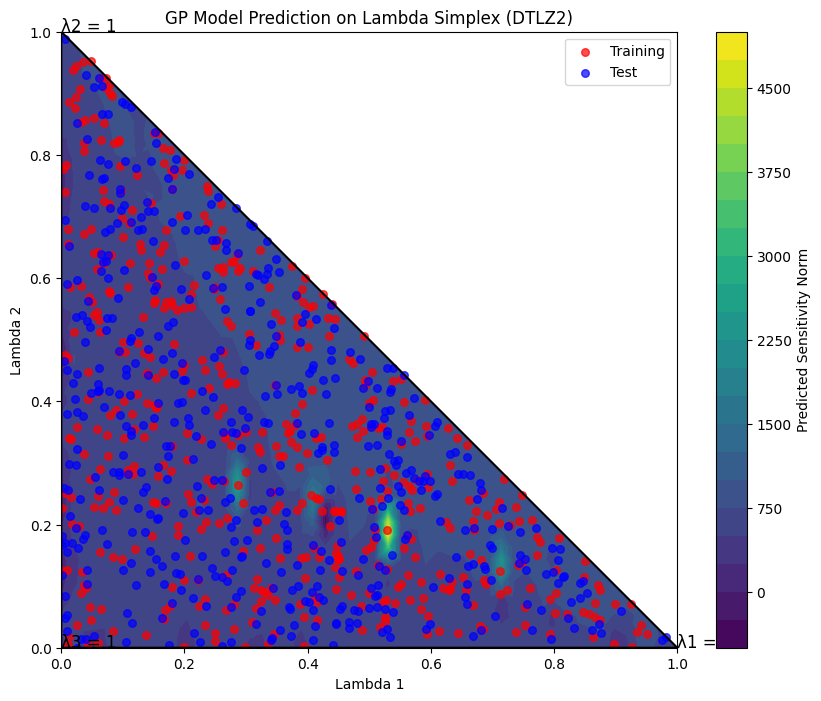

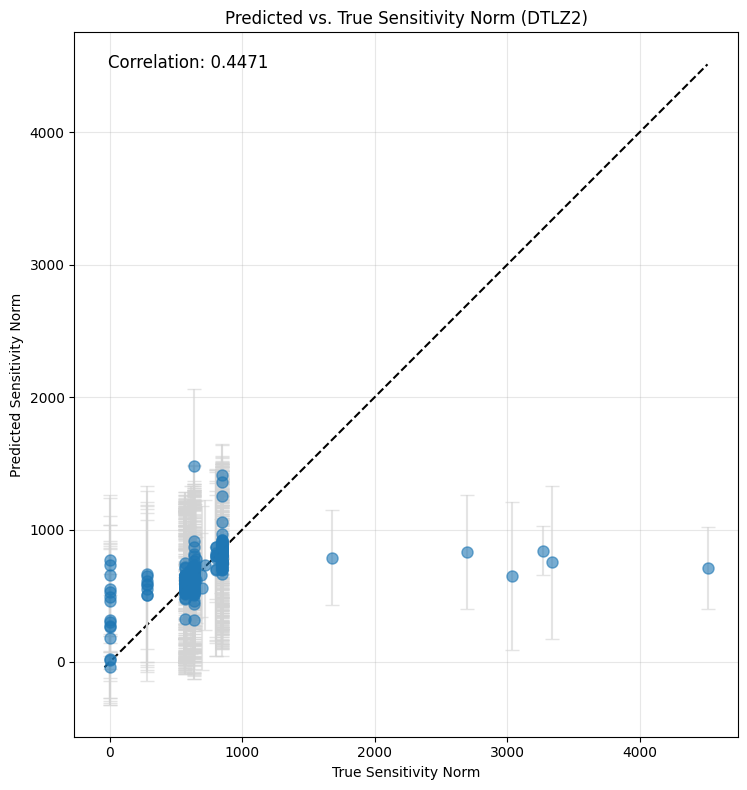

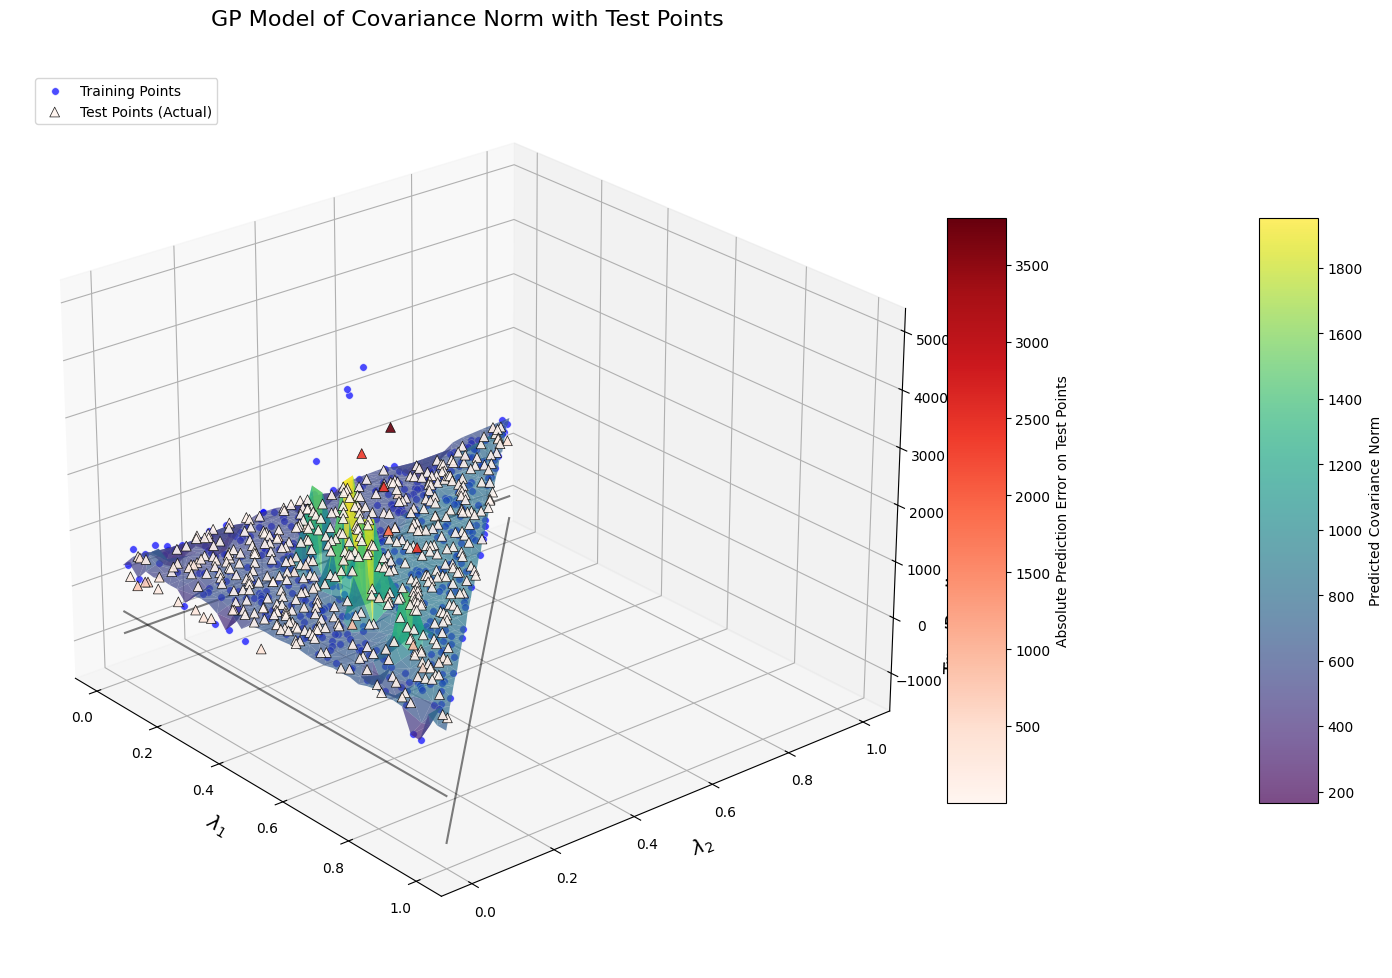


All visualizations have been saved.
Done!


In [37]:
def main():
    """Main function to orchestrate the GP modeling and evaluation for DTLZ2"""
    # Load the data
    print("Loading lambda-covariance data for DTLZ2...")
    data = load_lambda_covariance_data()
    print(f"Loaded {len(data)} samples.")
    
    # Ensure lambda3 is calculated to respect the simplex constraint
    data['lambda3'] = 1 - data['lambda1'] - data['lambda2']
    
    # Fit the GP model
    model, X_train, X_test, y_train, y_test, scaler_X, scaler_y = fit_gp_model(data, n_training=500)
    
    # Evaluate the model
    y_pred, y_std, metrics = evaluate_model(model, X_test, y_test, scaler_X, scaler_y)
    
    # Print metrics
    print("\nModel performance on test data:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")
    
    # Plot the GP surface with test points
    print("\nCreating visualizations...")
    plot_gp_surface_with_test_points(model, X_train, X_test, y_train, y_test, y_pred, 
                                    y_std, scaler_X, scaler_y)
    
    # Plot predicted vs true values
    plot_predicted_vs_true(y_test, y_pred, y_std)
    if len(X_test) > 0:  # Ensure there is test data to plot
        print("\nGenerating 3D GP Surface Plot...")
        test_errors = np.abs(y_test - y_pred)
        fig3d = plot_gp_surface_with_test_points_enhanced(
            model,
            X_train, y_train,  # Original unscaled training data
            X_test, y_test,    # Original unscaled test data
            y_pred,            # Unscaled predictions for test data
            test_errors,       # Absolute errors for test data
            scaler_X, scaler_y,  # Fitted scalers
            title_suffix="Covariance Norm"
        )
        # Save the figure
        fig3d.savefig('3d_gp_surface_plot.png', dpi=300)
    else:
        print("Skipping plots as there is no test data (or too few overall data points).")
        
    print("\nAll visualizations have been saved.")
    print("Done!")

if __name__ == "__main__":
    main()